## 서론

####**1. 데이터 선정 이유**

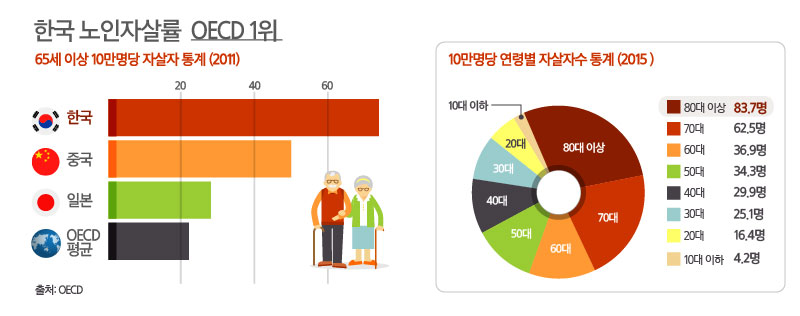

#### 문제 제기

- 한국의 노인 자살률은 OECD평균, 아시아 근처 국가와 비교해도 굉장히 높습니다.
- 노인자살 예방이 **필수적인 사회의 문제**로 떠오르고 있습니다.
- 머신러닝을 통해 복합적인 이유중 **`자살을 하는 주 요인이 어떤것인지 분석`**해 보도록 하겠습니다. 

#### DATA 

- 노인 분들이 많이 모이는 **종묘 탑골공원** 주변에서 **여가 생활 설문조사**를 시행하였고
-  질문지 중 삶에 대한 만족도(Target)를 5단계로 분류하여 만족하지 못하는 노인분들을 위험군으로 분류했습니다.



#### 가정은 아래와 같습니다. 

- 만족도가 매우 낮은 경우 자살을 할 확률이 높다.
- 자살을 하는 요인은 매우 복합적일 것이다.



**[종묘탑골공원 주변어르신 실태와 욕구조사]**

 설문조사를 이용하여 어르신들의 삶에 대한 만족도를 분류하는 모델을 만들어 보도록 하겠습니다.

## **IMPORT**

In [ ]:
!pip install --upgrade category_encoders

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn
import os
import io
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import f1_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [10]:
df = pd.read_excel('/content/gdrive/MyDrive/data/sc231/1. MD_2016년 어르신 여가생활 설문조사_개별면접.xlsx')

In [11]:
df = df.replace({'DQ63': {1: 1, 2:1 , 3:2, 4:2, 5:2}})
df
#타겟 변수를 바꾸어 주도록 하겠습니다.

ID  SQ0  SQ1  SQ2  SQ3  Q01  Q021  ...  DQ4  DQ5  DQ61  DQ62 DQ63 DQ64 DQ65
0      1.0  1.0  1.0  2.0  1.0  2.0   2.0  ...  4.0  3.0   3.0   2.0  1.0  2.0  1.0
1      2.0  1.0  1.0  2.0  1.0  2.0   2.0  ...  1.0  2.0   3.0   3.0  1.0  2.0  3.0
2      3.0  1.0  1.0  2.0  1.0  2.0   1.0  ...  1.0  2.0   3.0   2.0  2.0  2.0  3.0
3      4.0  1.0  1.0  2.0  1.0  2.0   2.0  ...  1.0  2.0   3.0   3.0  1.0  2.0  3.0
4      5.0  1.0  1.0  2.0  1.0  2.0   2.0  ...  2.0  3.0   1.0   1.0  1.0  1.0  1.0
..     ...  ...  ...  ...  ...  ...   ...  ...  ...  ...   ...   ...  ...  ...  ...
518  620.0  3.0  1.0  2.0  1.0  2.0   1.0  ...  1.0  2.0   2.0   2.0  2.0  3.0  3.0
519  621.0  5.0  1.0  2.0  1.0  3.0   2.0  ...  1.0  4.0   2.0   4.0  2.0  3.0  3.0
520  622.0  5.0  1.0  2.0  1.0  2.0   2.0  ...  1.0  4.0   3.0   4.0  2.0  3.0  2.0
521  623.0  5.0  1.0  2.0  1.0  3.0   2.0  ...  2.0  3.0   2.0   3.0  2.0  2.0  3.0
522  624.0  5.0  1.0  2.0  1.0  4.0   1.0  ...  1.0  4.0   4.0   3.0  2.0  4.0  3.0

[523 rows x 236 columns]


DQ63 (동의 정도) 나는 내 인생에 만족한다 /라는 숨겨진 타겟변수를 살펴보도록 하겠습니다.

1. 전혀 그렇지 않다.
2. 그렇지 않다.
3. 그저 그렇다
4. 그렇다.
5. 매우 그렇다.

1과 2를 위험군으로 분류합니다.

2.0    0.543021
1.0    0.456979
Name: DQ63, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


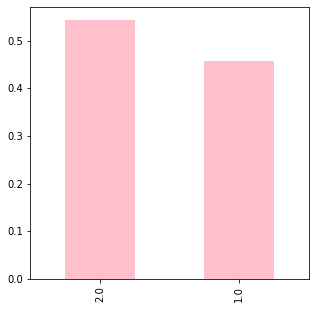

In [21]:
target = 'DQ63'
plt.figure(figsize=(5,5))
print(df[target].value_counts(normalize=True))
print(df[target].value_counts(normalize=True).plot.bar(color='pink')) # pink => 이쁨

밸런스가 어느정도 맞추어져 있습니다. 

#NULL!    0.491396
2.0       0.231358
3.0       0.139579
1.0       0.095602
5.0       0.032505
4.0       0.005736
6.0       0.003824
Name: Q041, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


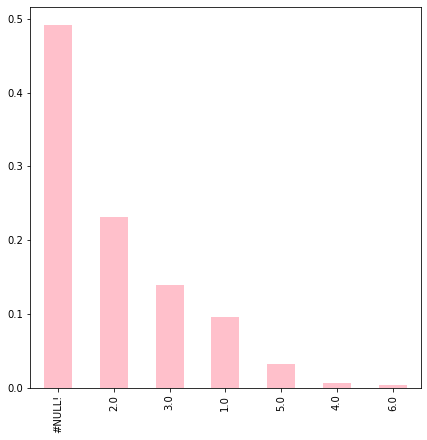

In [22]:
plt.figure(figsize=(7,7))
print(df['Q041'].value_counts(normalize=True))
print(df['Q041'].value_counts(normalize=True).plot.bar(color='pink'))

오전 시간에 자주 머무르는 지역(중복응답)

2. 탑골공원과 주변거리 
3. 낙원상가

- 두 항목이 가장 큰 값을 차지하고 
- **Null 값은 결측치가 아니라 미응답**입니다. => 채울때 참고
- 절반이 미응답을 고른것으로 확인됩니다.


설문조사 파일이라 크게 전처리를 할 필요가 없어 보입니다.

In [25]:
#열 타입이 정수 97개 오브젝트형 139 개 입니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Columns: 236 entries, ID to DQ65
dtypes: float64(97), object(139)
memory usage: 964.4+ KB


In [24]:
df.isnull().sum().sort_values(ascending = False)
#결측치 확인

ID        0
Q2251     0
Q2211     0
Q2212     0
Q2213     0
         ..
Q09203    0
Q09204    0
Q09205    0
Q09206    0
DQ65      0
Length: 236, dtype: int64

결측치는 없습니다.Null 값은 결측치가 아니라 미응답입니다.

In [26]:
#검증 트레이닝 데이터 나누기
target = 'DQ63'

train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)
train.shape, test.shape

((418, 236), (105, 236))

In [27]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((334, 236), (84, 236), (105, 236))

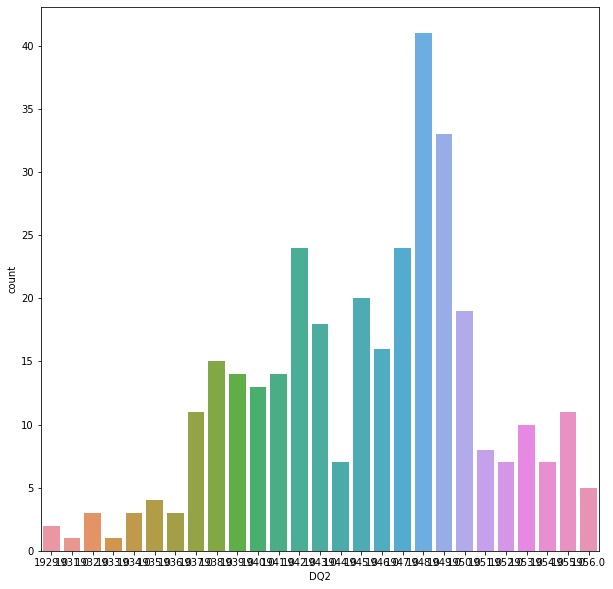

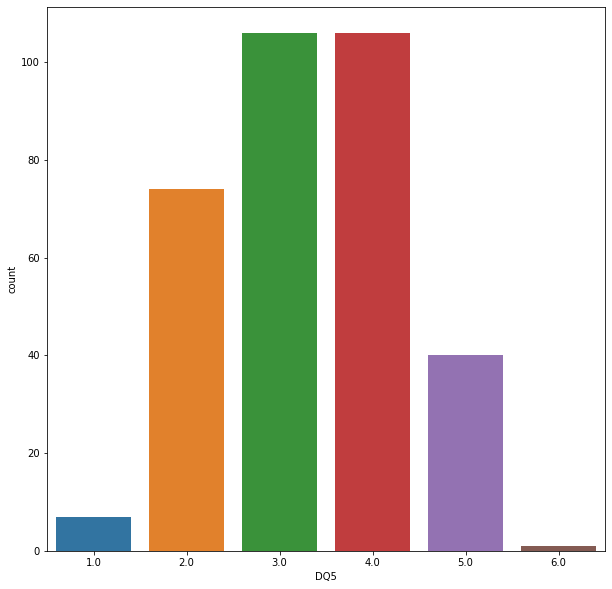

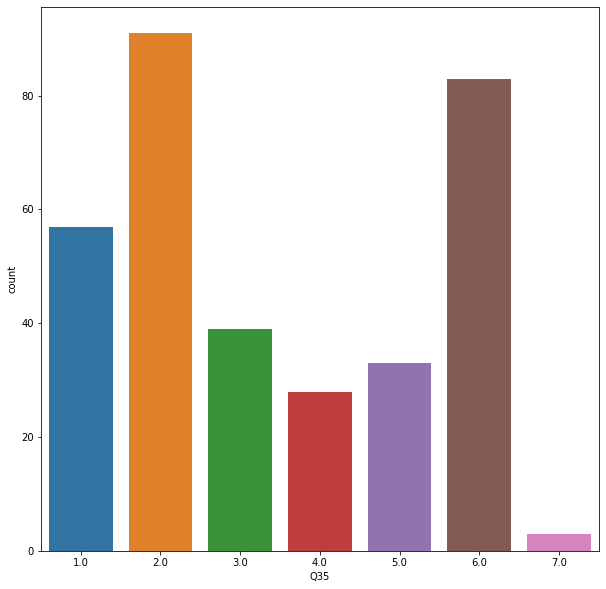

In [32]:
plt.figure(figsize=(10,10))
sns.countplot(x="DQ2", data=train) #태어난 년도 
plt.show();

plt.figure(figsize=(10,10))
sns.countplot(x="DQ5", data=train)
plt.show(); # 최종학력 1.무학 2. 초 3.중 4.고 5.대 6.대학원

plt.figure(figsize=(10,10))
sns.countplot(x="Q35", data=train)
plt.show();#향후 종묘/탑골공원 주변에 어르신들을 위한 시설 생긴다면, 우선적으로 필요한 시설(중복응답) 2. 복지시설 5. 무료급식시설

In [33]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]


X_train.shape, X_val.shape,y_train.shape, y_val.shape, X_test.shape ,y_test.shape

((334, 235), (84, 235), (334,), (84,), (105, 235), (105,))

## **모델 생성**

- score로는  정확도 뿐만아니라 
리컬, 프레시전, 그리고 이둘을 조합한 F1 score 을 사용하도록 하겠습니다! 
- 변수 중요도를 판단하기 위해 Tree based 모델 중 DecisionTree를 사용합니다. 

In [37]:
pipe_decision = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=20,max_depth=10)
)
  
pipe_decision.fit(X_train, y_train)

print()
print("train 정확도: ", pipe_decision.score(X_train, y_train))
print("validation 정확도: ", pipe_decision.score(X_val, y_val))
#f1
y_pred_decision = pipe_decision.predict(X_val)
print("validation f1_score: ", f1_score(y_val, y_pred_decision))


train 정확도:  1.0
validation 정확도:  0.7738095238095238
validation f1_score:  0.765432098765432


#### Hyper parameter를 튜닝해 주겠습니다.

In [35]:
sorted(pipe_decision.get_params().keys())
#하이퍼 파라미터 조절가능한 것들을 나열하겠습니다.

['decisiontreeclassifier',
 'decisiontreeclassifier__ccp_alpha',
 'decisiontreeclassifier__class_weight',
 'decisiontreeclassifier__criterion',
 'decisiontreeclassifier__max_depth',
 'decisiontreeclassifier__max_features',
 'decisiontreeclassifier__max_leaf_nodes',
 'decisiontreeclassifier__min_impurity_decrease',
 'decisiontreeclassifier__min_samples_leaf',
 'decisiontreeclassifier__min_samples_split',
 'decisiontreeclassifier__min_weight_fraction_leaf',
 'decisiontreeclassifier__random_state',
 'decisiontreeclassifier__splitter',
 'memory',
 'simpleimputer',
 'simpleimputer__add_indicator',
 'simpleimputer__copy',
 'simpleimputer__fill_value',
 'simpleimputer__missing_values',
 'simpleimputer__strategy',
 'simpleimputer__verbose',
 'steps',
 'targetencoder',
 'targetencoder__cols',
 'targetencoder__drop_invariant',
 'targetencoder__handle_missing',
 'targetencoder__handle_unknown',
 'targetencoder__min_samples_leaf',
 'targetencoder__return_df',
 'targetencoder__smoothing',
 'targete

In [38]:
from sklearn.model_selection import GridSearchCV

dists_ = {    
    'decisiontreeclassifier__class_weight': ['balanced', 'None'], 
    'decisiontreeclassifier__max_depth' : [5, 10, 15],
    'decisiontreeclassifier__min_samples_split' :[2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf' : [5, 10, 15, 20],
    'decisiontreeclassifier__criterion' : ['entropy','None'],
    'targetencoder__min_samples_leaf' : [10, 50, 100]
}


clf_ = GridSearchCV(
    estimator= pipe_decision, 
    param_grid = dists_, 
    cv=3, 
    n_jobs=-1
)

clf_.fit(X_train, y_train);


print('최적 하이퍼파라미터: ', clf_.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
972 fits failed out of a total of 1296.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-package

최적 하이퍼파라미터:  {'decisiontreeclassifier__class_weight': 'balanced', 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 5, 'decisiontreeclassifier__min_samples_split': 2, 'targetencoder__min_samples_leaf': 100}


최적 하이퍼파라미터:  

{'decisiontreeclassifier__class_weight': 'balanced', 

'decisiontreeclassifier__criterion': 'entropy', 

'decisiontreeclassifier__max_depth': 10, 

'decisiontreeclassifier__min_samples_leaf': 9, 

'decisiontreeclassifier__min_samples_split': 2, 

'targetencoder__min_samples_leaf': 100}

In [49]:
pipe_decision = make_pipeline(
    TargetEncoder(min_samples_leaf = 100), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=20,
                           max_depth=10,
                           min_samples_leaf = 9,
                           min_samples_split = 3,
                           class_weight = 'balanced',
                           criterion = 'entropy')
)
  
pipe_decision.fit(X_train, y_train)

print()
print("train 정확도: ", pipe_decision.score(X_train, y_train))
print("validation 정확도: ", pipe_decision.score(X_val, y_val))
#f1
y_pred_decision = pipe_decision.predict(X_val)
print("validation f1_score: ", f1_score(y_val, y_pred_decision))


train 정확도:  0.8982035928143712
validation 정확도:  0.8095238095238095
validation f1_score:  0.7948717948717949


#### 트리 구성을 확인해 보겠습니다.

- 루트노드(Root Node) : 시작점
- 리프노드(Leaf Node) : 결정된 클래스 값
- 규칙노드/내부노드(Decision Node / Internal Node) : 데이터세트의 피처가 결합해 만들어진 분류를 위한 규칙조건

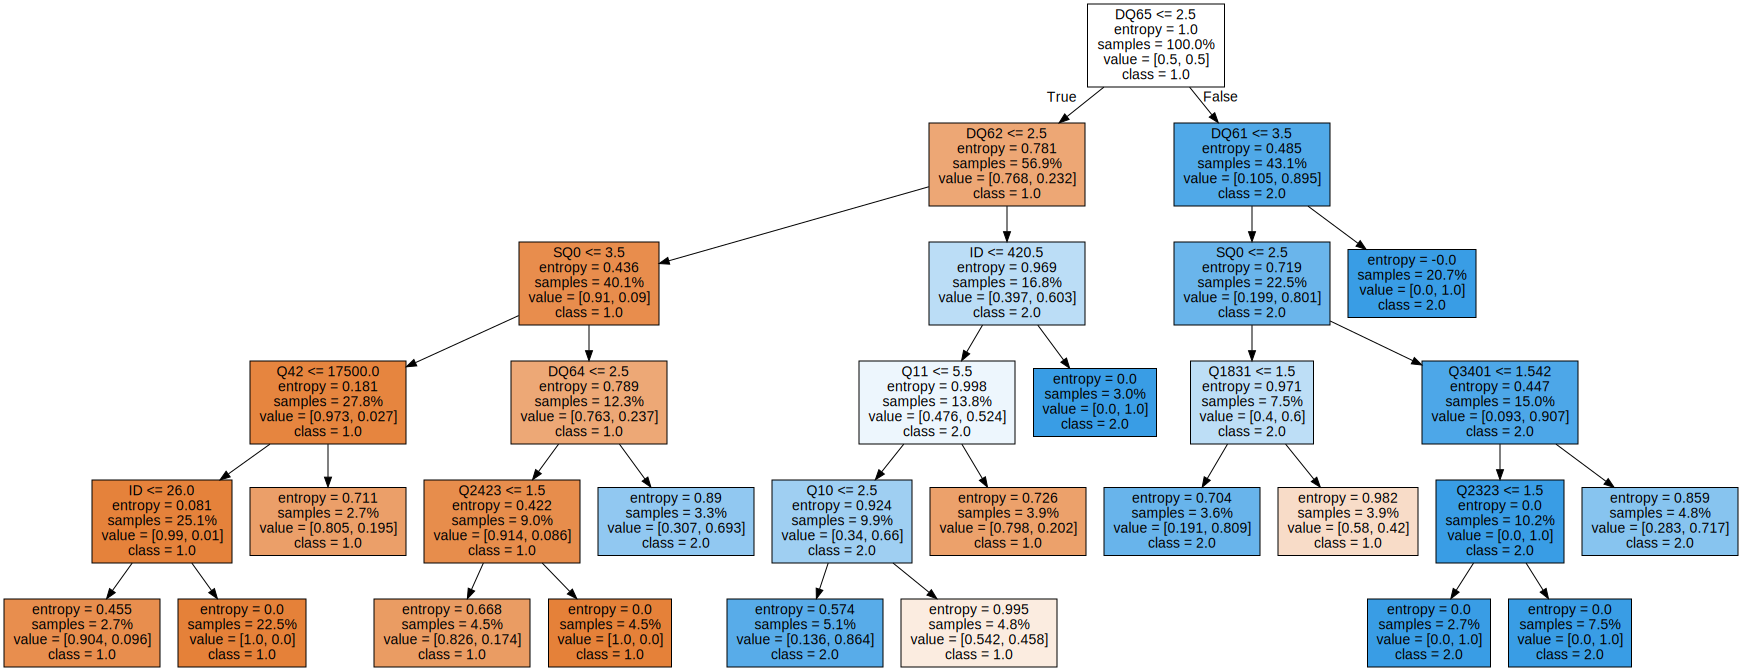

In [78]:
import graphviz
import pydotplus
from sklearn.tree import export_graphviz

tree = pipe_decision.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    proportion=True
)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('original_tree.png')
pydot_graph.set_size('"13,20!"')
graphviz.Source(dot_data)

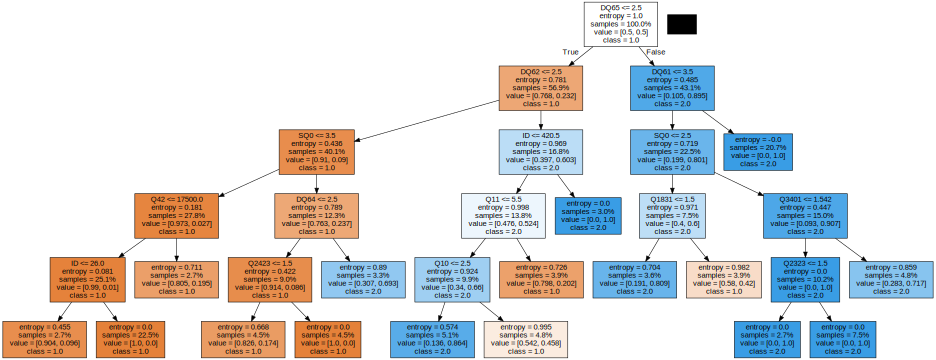

In [79]:
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

- DQ 64행은  - (동의 정도) 지금까지 나는 내 인생에서 원했던 중요한 것들을 가질 수 있었다 이므로 삶의 만족도 타겟 피쳐에 유출될 가능성이 큽니다. 삭제해 주도록 하겠습니다.

- DQ 62행은 - (동의 정도) 내 인생의 여건들은 매우 좋은 편이다
- DQ 61행은 - (동의 정도) 여러 가지 면에서 내 인생은 이상적으로 생각했던 인생과 가깝다
- DQ 65행은 - (동의 정도) 다시 산다고 하더라도 지금처럼 살고 싶다.



---

맨처음 , DQ 65를 기준으로 2.5 이하인지 아닌지를 확인합니다. **다시 산다고 하더라도 지금처럼 살고 싶다** 라는 질문인데, 매우 광범위한 질문이라 다음 질문을 보도록 하겠습니다.

그렇지 않다면 DQ61(이상적으로 생각했던 인생) <= 3.5 , 그렇다면 DQ62(여건들은 매우 좋은 편) <= 2.5 입니다. 이상적인 인생인지 아닌지는 3.5점을 넘기느냐 마느냐 (= 지금처럼 살고싶은 쪽이지만 이상적인 인생은 보통이어도 어느정도 괜찮음)이지만, 여건에 대해서는 지금처럼 살고 싶더라도 (보통보다 기준점이 약간 낮습니다.)


이렇게 보면 수치적으로 어느 변수가 얼마나 영향을 미치는지 확인할 수 있습니다. 변수 중요도를 확인해보겠습니다.



#### 변수를 삭제하고 보고 싶을때는 아래와 같이 삭제하고 다시 모델을 만들어 측정해줍니다. 

In [ ]:
# features = df.columns.drop([target
#                             , 'DQ64'
#                             , 'DQ62'
#                             , 'DQ65'
#                            ])
# X_train = train[features]
# y_train = train[target]

# X_val = val[features]
# y_val = val[target]

# X_test = test[features]
# y_test = test[target]


# X_train.shape, X_val.shape,y_train.shape, y_val.shape, X_test.shape ,y_test.shape

####**모델 해석 및 분석(검증)** 

In [81]:
!pip install eli5

In [82]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import Pipeline

In [ ]:
!pip install pdpbox
!pip install shap

#### **feature_importances_**

Q07304    0.000000e+00
Q07305    0.000000e+00
Q07306    0.000000e+00
Q09202    0.000000e+00
Q07308    0.000000e+00
Q07307    0.000000e+00
Q07309    0.000000e+00
Q07310    0.000000e+00
Q08       0.000000e+00
Q092      0.000000e+00
Q09106    0.000000e+00
Q09105    0.000000e+00
Q091      0.000000e+00
Q09101    0.000000e+00
Q09104    0.000000e+00
Q09102    0.000000e+00
Q09103    0.000000e+00
Q2323     1.065057e-16
Q1831     1.241467e-02
Q2423     1.296260e-02
Q42       1.763496e-02
Q10       1.917751e-02
Q11       2.611981e-02
Q3401     3.287580e-02
ID        4.559806e-02
DQ64      4.608081e-02
DQ61      6.049888e-02
SQ0       7.324040e-02
DQ62      1.688362e-01
DQ65      4.845603e-01
dtype: float64

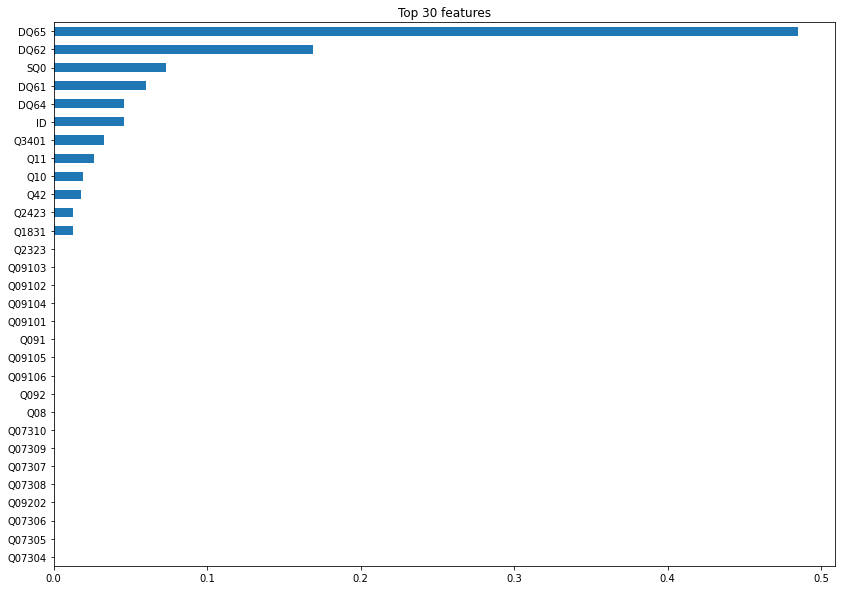

In [85]:
rf = pipe_decision.named_steps['decisiontreeclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n = 30 # 30개만 확인
plt.figure(figsize=(14,10))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();
importances.sort_values()[-n:]

- DQ65(동의 정도) 다시 산다고 하더라도 지금처럼 살고 싶다
- DQ62(동의 정도) 내 인생의 여건들은 매우 좋은 편이다
- SQ0현재 조사 진행 장소
- DQ61(동의 정도) 여러 가지 면에서 내 인생은 이상적으로 생각했던 인생과 가깝다
- DQ64(동의 정도) 지금까지 나는 내 인생에서 원했던 중요한 것들을 가질 수 있었다
- Q3401종묘/탑골공원 주변 환경 정비에 있어 바라는 점(중복응답)
- Q11종묘탑골공원 주변 이용하는 이유(중복응답)
- Q10종묘탑골공원 주변 지역에서 보내는 하루 생활 전반적 만족도
- Q42이 지역에서 하루 평균 사용 용돈(원)
- Q2423[향후 이용 여부] 어르신 이동 상담소
- Q1831[인지도] 실버영화관

In [86]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

#### **pdp**

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


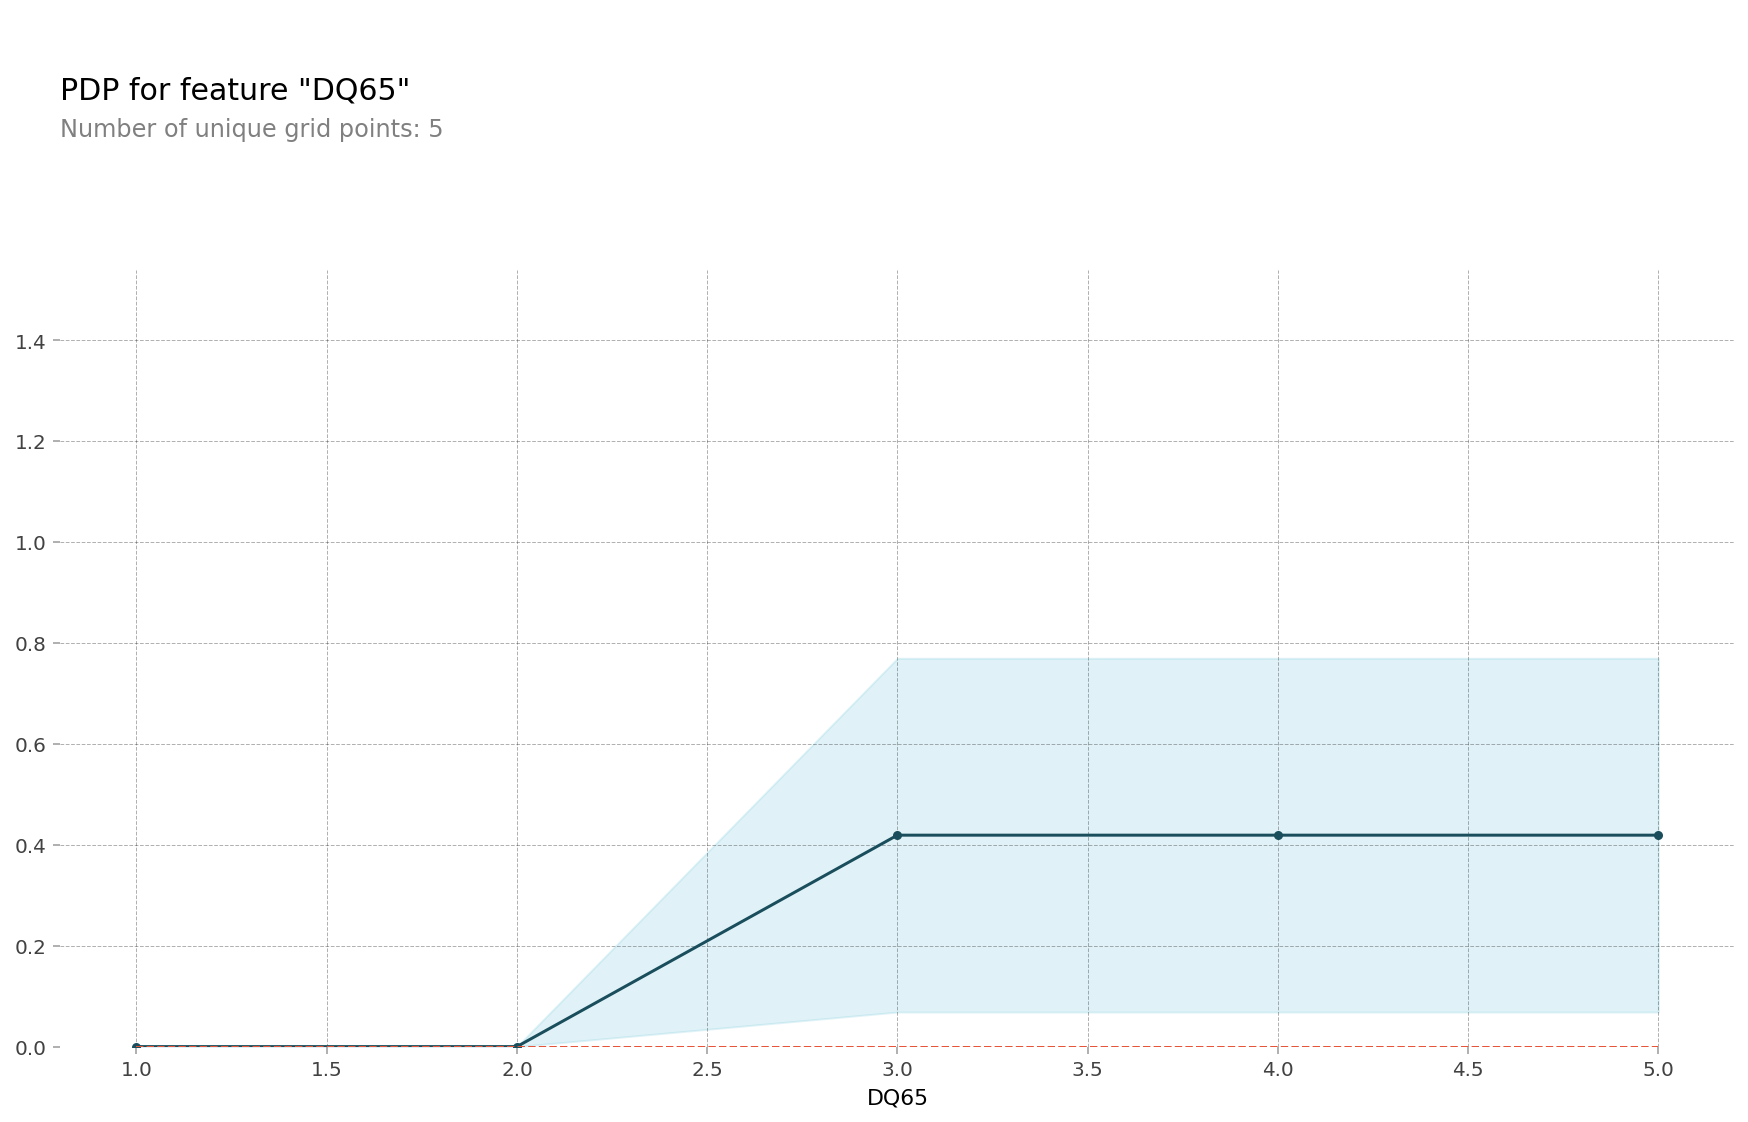

In [87]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'DQ65'

isolated = pdp_isolate(
    model=pipe_decision, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

DQ61이라는 (동의 정도) 여러 가지 면에서 내 인생은 이상적으로 생각했던 인생과 가깝다 값이 올라갈수록 모델의 성능도 변하는 것을 볼 수 있습니다.

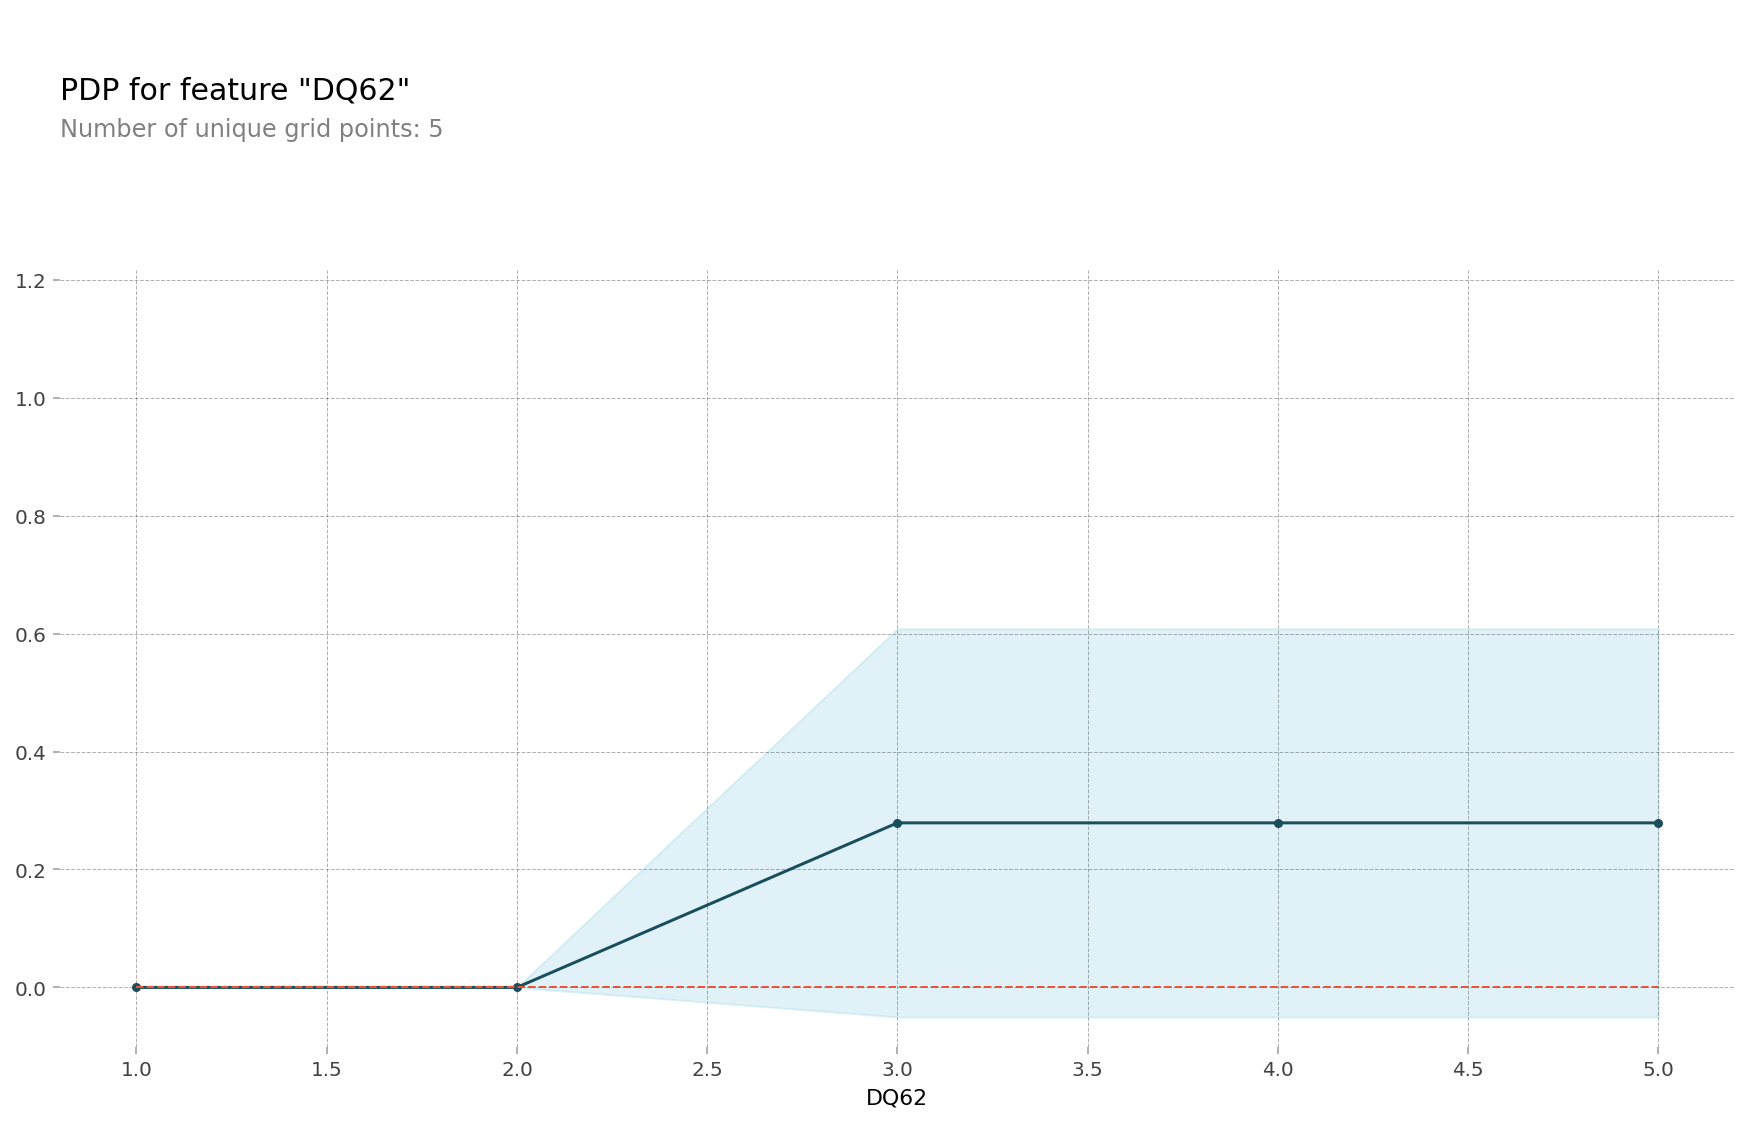

In [90]:
dq62 = 'DQ62'

isolated = pdp_isolate(
    model=pipe_decision, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=dq62
)
pdp_plot(isolated, feature_name=dq62);

In [ ]:
# DQ62 - (동의 정도) 내 인생의 여건들은 매우 좋은 편이다
dq62 = 'DQ62'

isolated = pdp_isolate(
    model=pipe_decision, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=dq62
)
pdp_plot(isolated, feature_name=dq62);

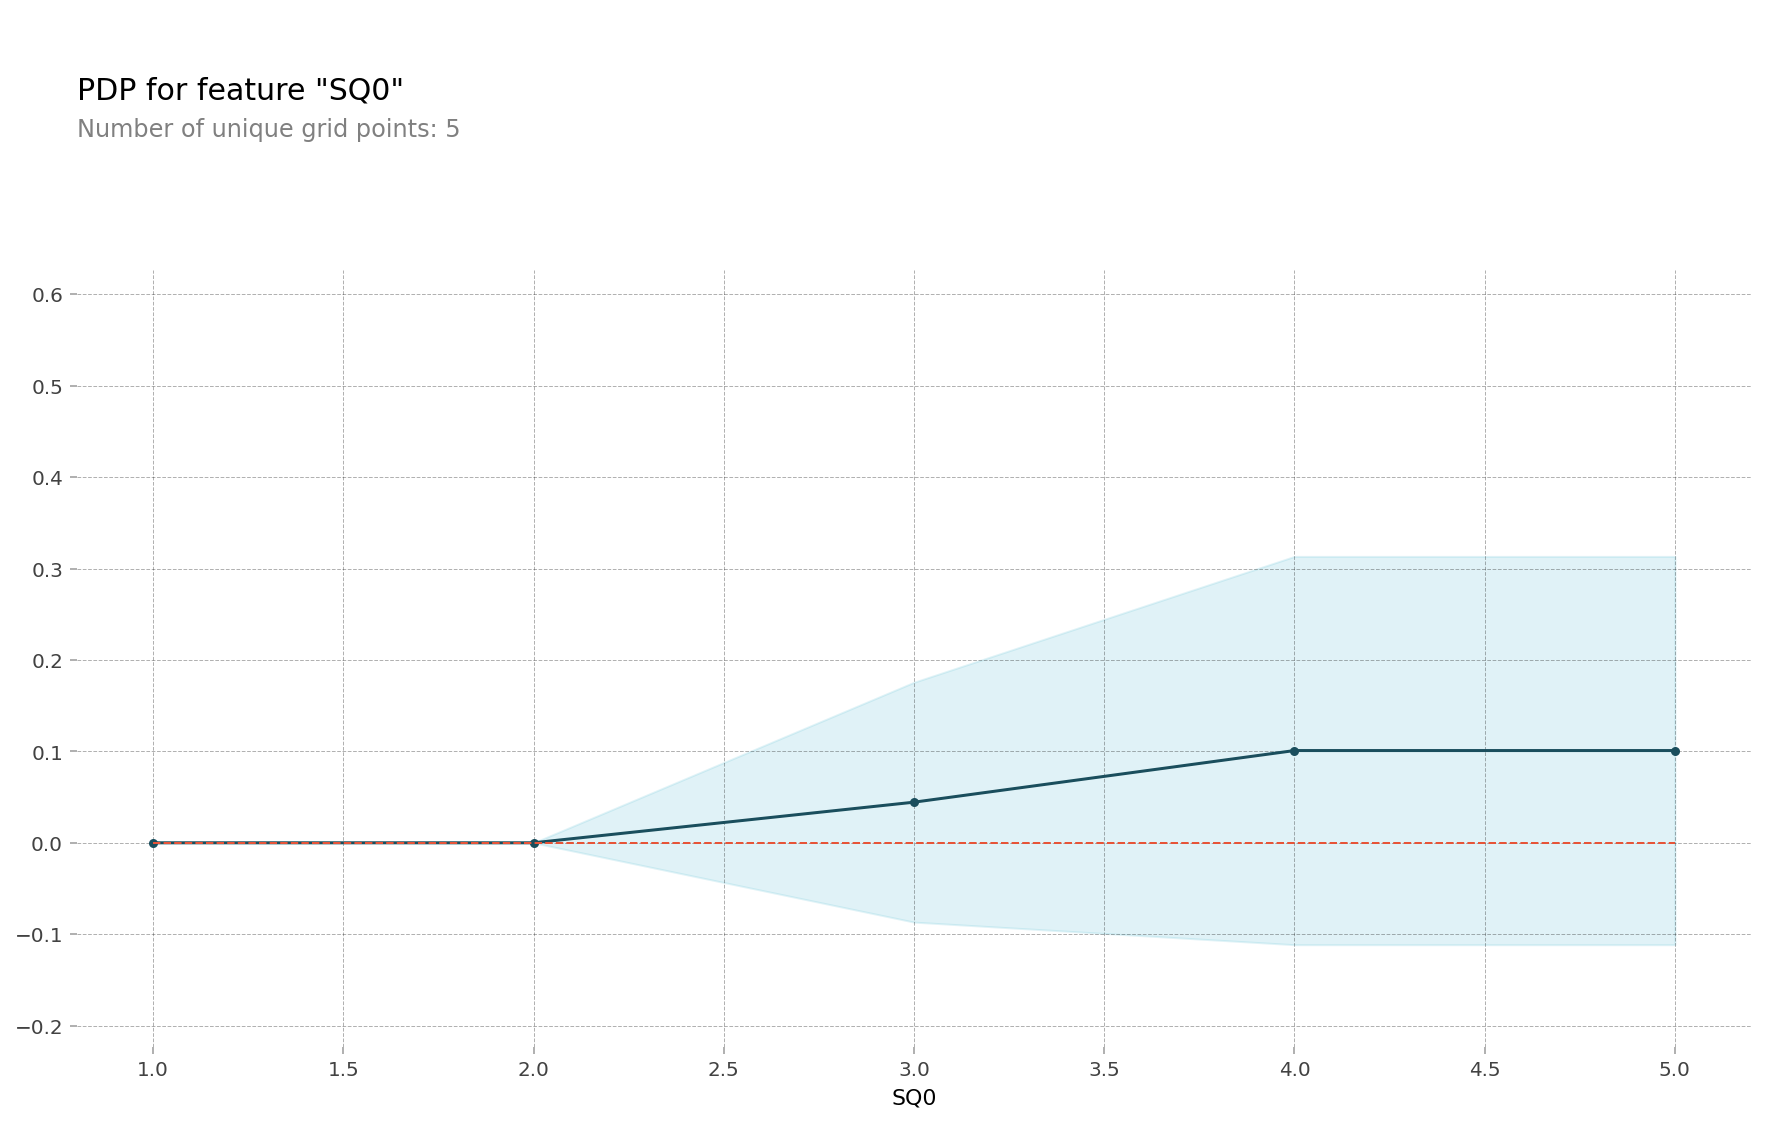

In [91]:
# SQ0 - 현재 조사 진행 장소
SQ0 = 'SQ0'

isolated = pdp_isolate(
    model=pipe_decision, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=SQ0
)
pdp_plot(isolated, feature_name=SQ0);

- 2점까지는 동일하다가 완만하게 4점까지 증가하는 라인 그래프를 보여줍니다.
    - 특히 4,5점이 미치는 영향력이 큽니다. 이는 종묘공원 ,피카디리 & 종로3가역 주변에서 설문조사를 한 분들이 **‘삶의 만족도’를 예측하는데 조금 더 큰 영향을 미치는 대답을 했습니다.**
    - 즉, 종묘공원 ,피카디리 & 종로3가역 주변에서 실시 할 수록 삶의 만족도가 증가하는데 큰 영향을 준다는 사실을 알 수 있습니다.
    - 단순히 우연인지, 혹은 종묘공원 ,피카디리 & 종로3가역 주변에 노인분들이 만족할만한 무언가가 있는지 확인하는 과정이 필요합니다.



---


- Q11종묘탑골공원 주변 이용하는 이유(중복응답)
- Q10종묘탑골공원 주변 지역에서 보내는 하루 생활 전반적 만족도

    - **위 두 질문도 확인해 보겠습니다.**

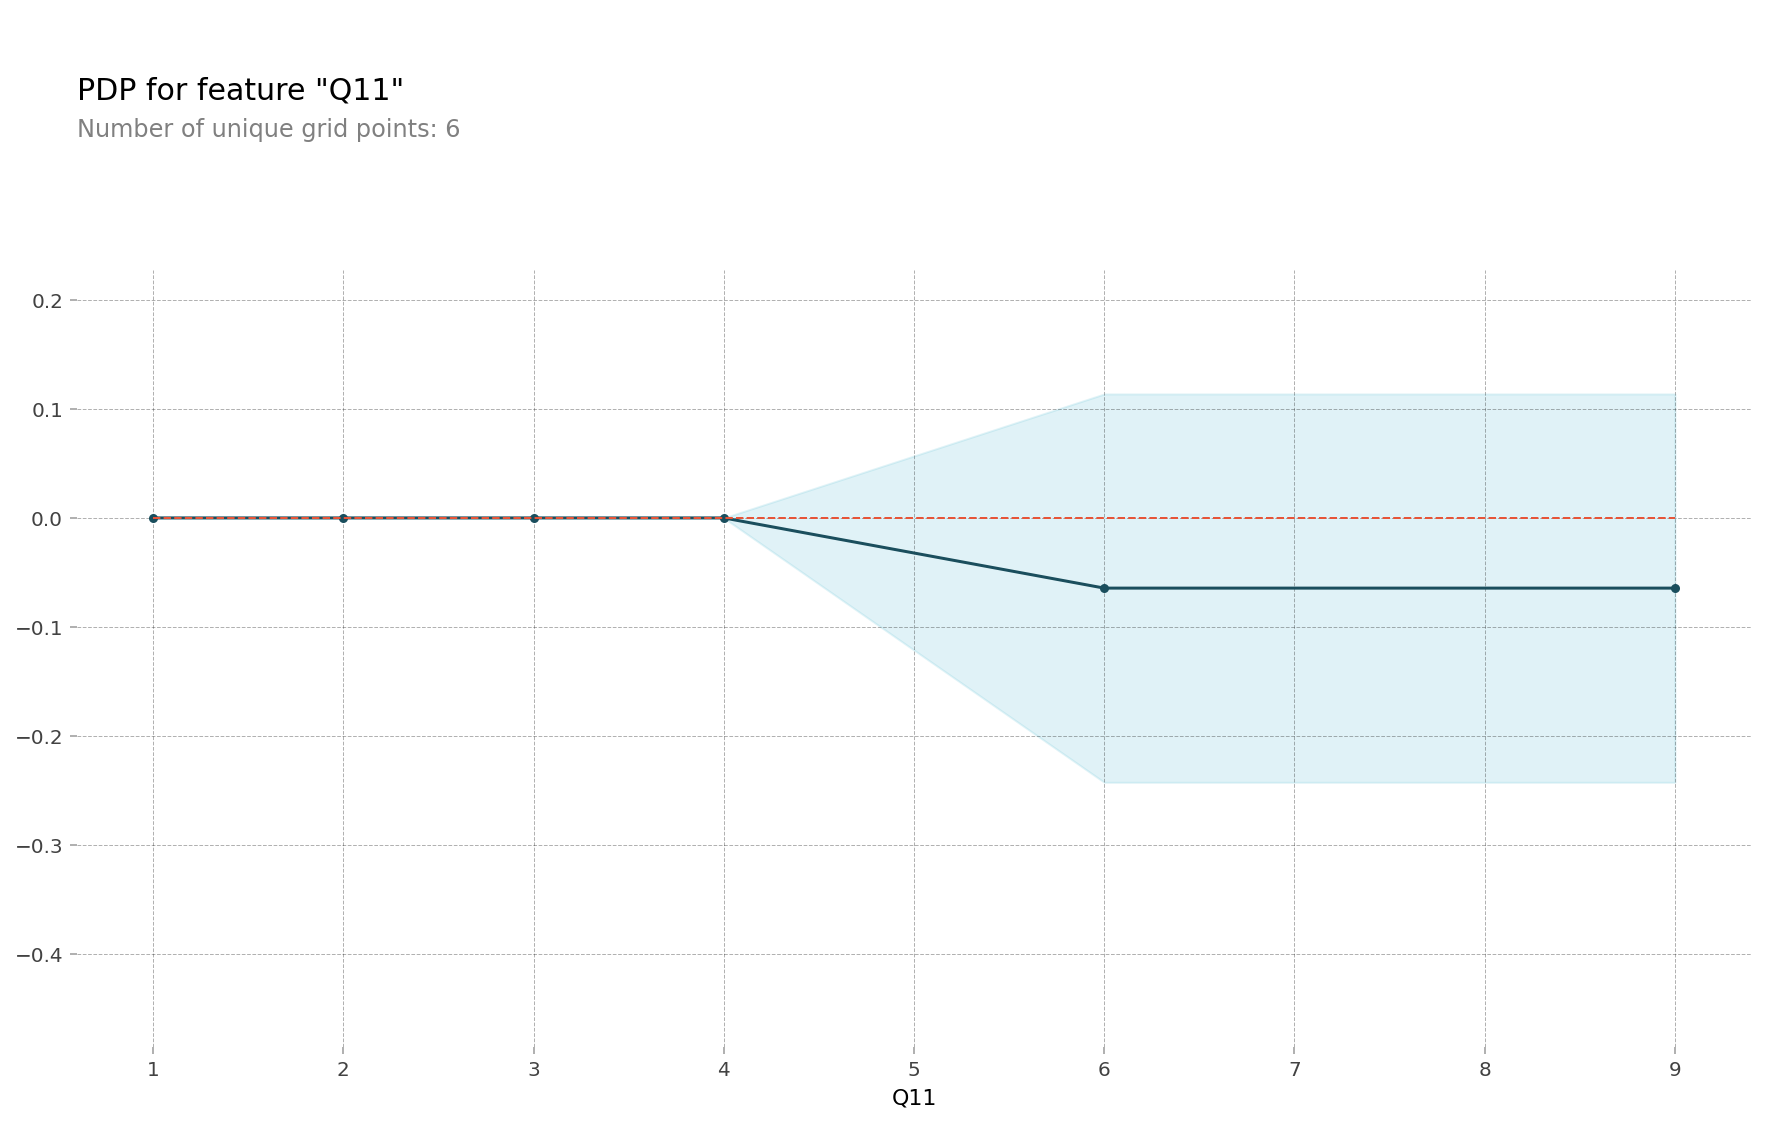

In [92]:
# Q11 종묘탑골공원 주변 이용하는 이유(중복응답)

Q11 = 'Q11'

isolated = pdp_isolate(
    model=pipe_decision, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=Q11
)
pdp_plot(isolated, feature_name=Q11);

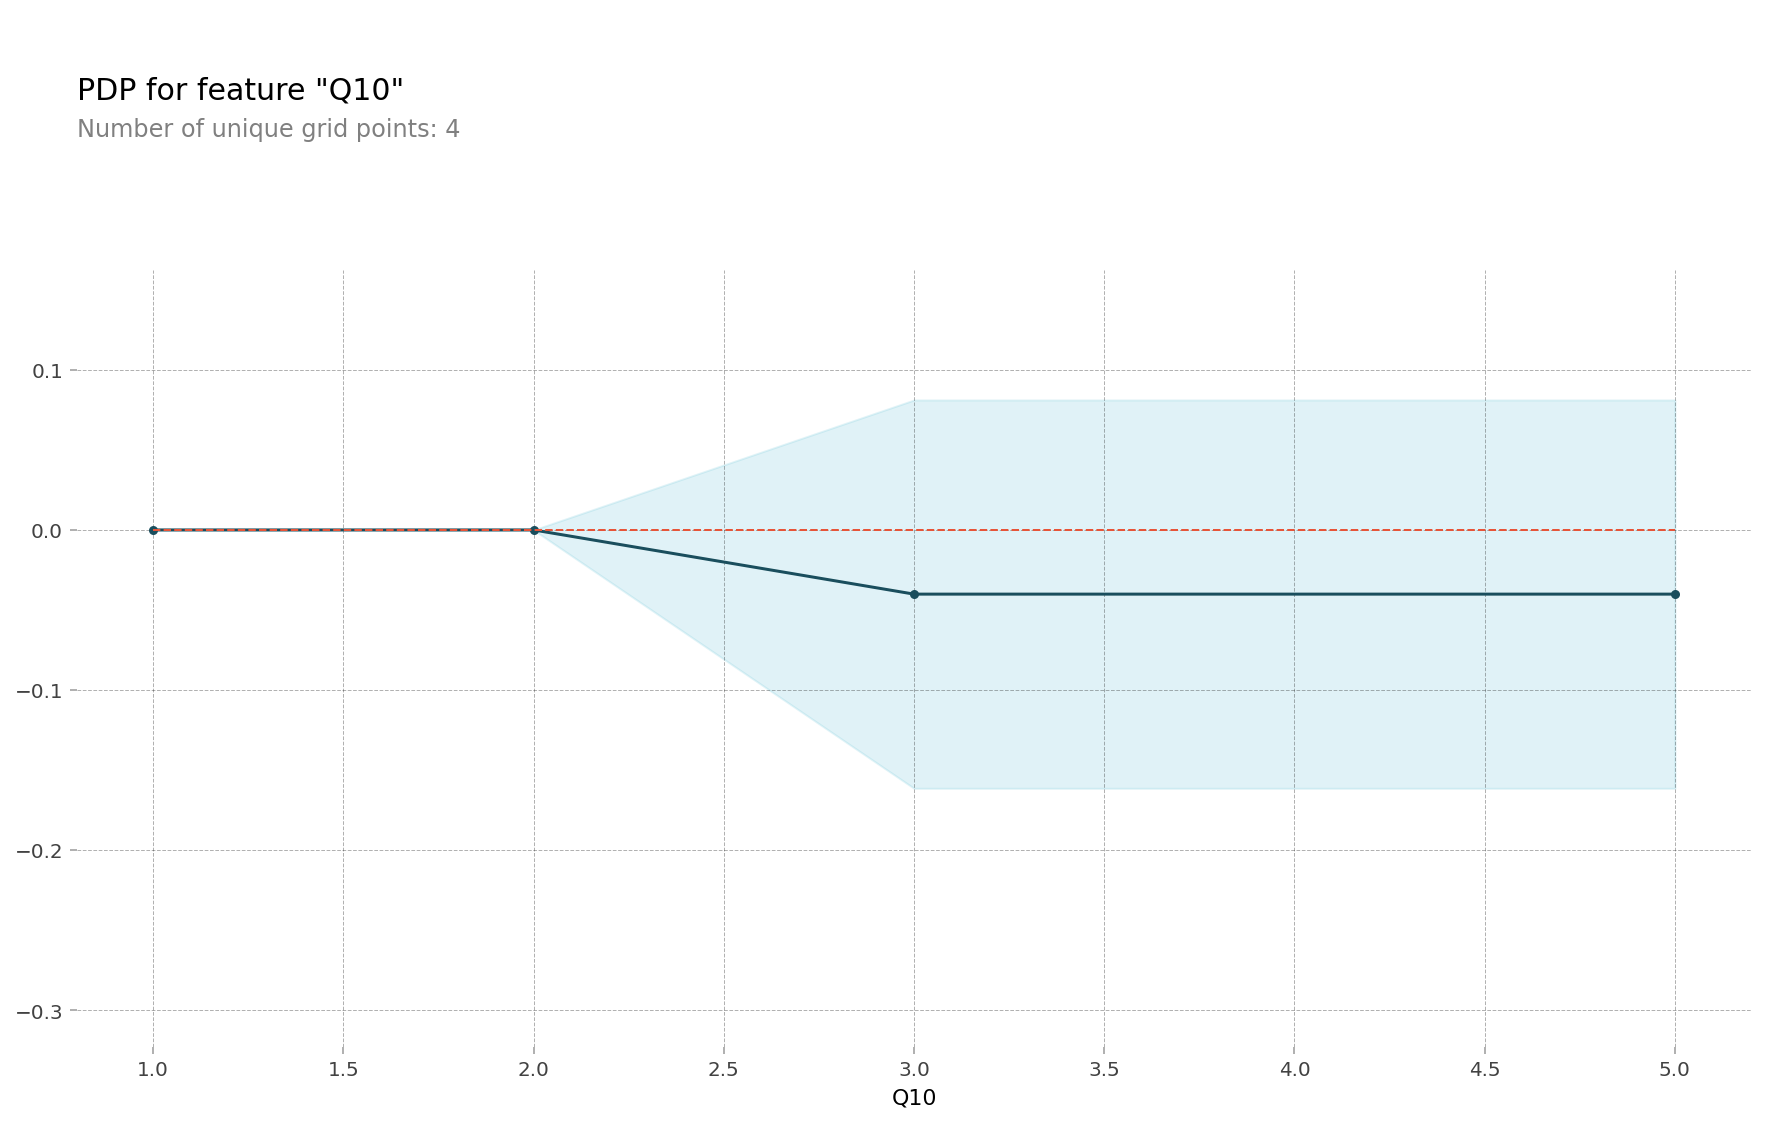

In [93]:
# Q10 종묘탑골공원 주변 지역에서 보내는 하루 생활 전반적 만족도

Q10 = 'Q10'

isolated = pdp_isolate(
    model=pipe_decision, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=Q10
)
pdp_plot(isolated, feature_name = Q10);

- 질문지를 살펴보니 1번부터 5번까지는 여러명이서 하는 일, 6번부터는 혼자서 하는 일(+ 추상적인 일) 입니다.
- 탑골공원에 오는 이유가 개인적인 사유가 될수록 만족도가 낮아집니다.
    - 이를 통해 ‘외로움' 및 시간 해결이 가장 문제 아닐까 하는 가설을 하나 더 세울 수 있습니다.

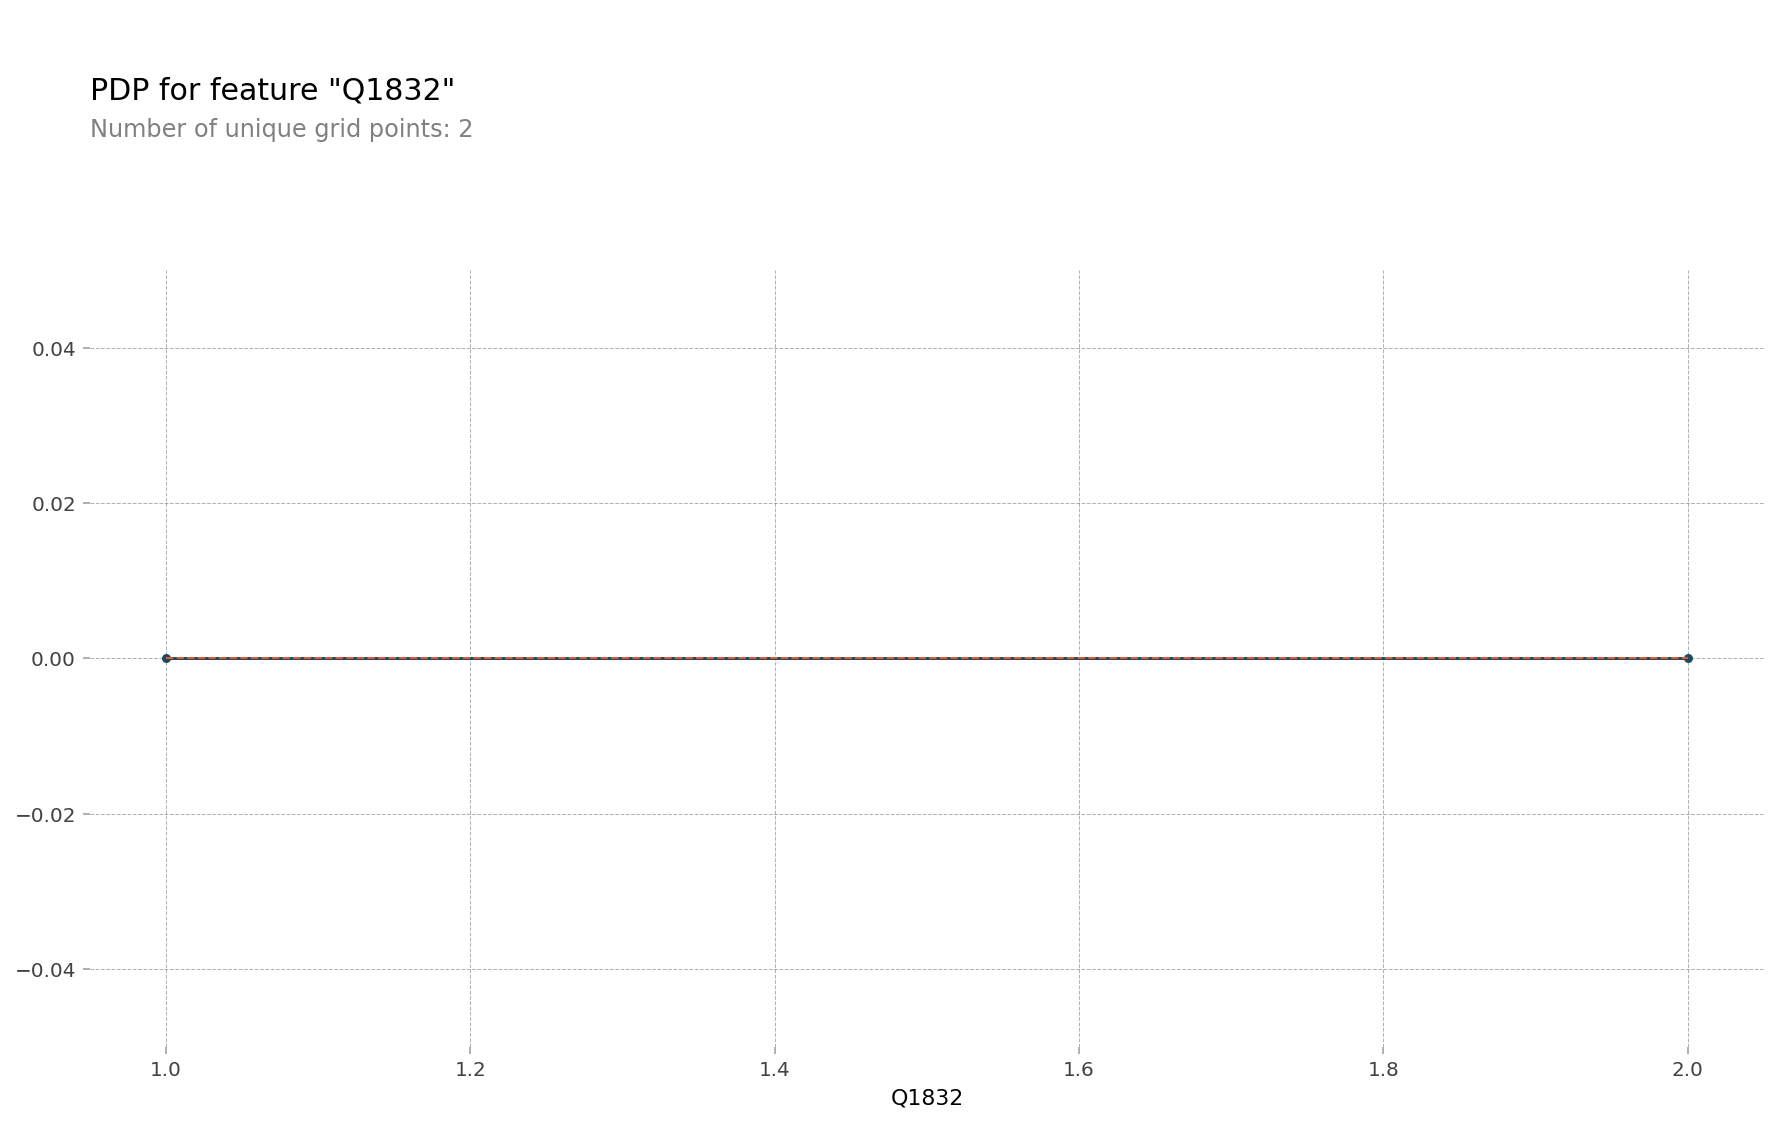

In [94]:
# Q1832[경험여부] 실버영화관을 마지막으로 살펴보겠습니다.

Q1832 = 'Q1832'

isolated = pdp_isolate(
    model=pipe_decision, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=Q1832
)
pdp_plot(isolated, feature_name = Q1832);

#### **SHAP**

In [95]:
test_id = X_test['ID']

In [ ]:
ratio = 0.45/0.54
ratio

0.8333333333333333

In [96]:
target = 'DQ63'
X = df.drop(columns=target)
y = df[target]

In [100]:
model = pipe_decision
from sklearn.metrics import classification_report
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         1.0       0.79      0.85      0.82        48
         2.0       0.87      0.81      0.84        57

    accuracy                           0.83       105
   macro avg       0.83      0.83      0.83       105
weighted avg       0.83      0.83      0.83       105



In [ ]:
import shap


shap_values = explainer.shap_values(pipe[:-1].transform(X_tr))


shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [125]:
import shap

explainer = shap.TreeExplainer(pipe_decision.named_steps["decisiontreeclassifier"])
shap_values = explainer.shap_values(pipe_decision[:-1].transform(X_train))

shap.initjs()
shap.force_plot(
   explainer.expected_value[0], shap_values[0])

In [129]:
shap.initjs()
# 총 13개 특성의 Shapley value를 절댓값 변환 후 각 특성마다 더함 -> np.argsort()는 작은 순서대로 정렬, 큰 순서대로 정렬하려면
# 앞에 마이너스(-) 기호를 붙임
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))


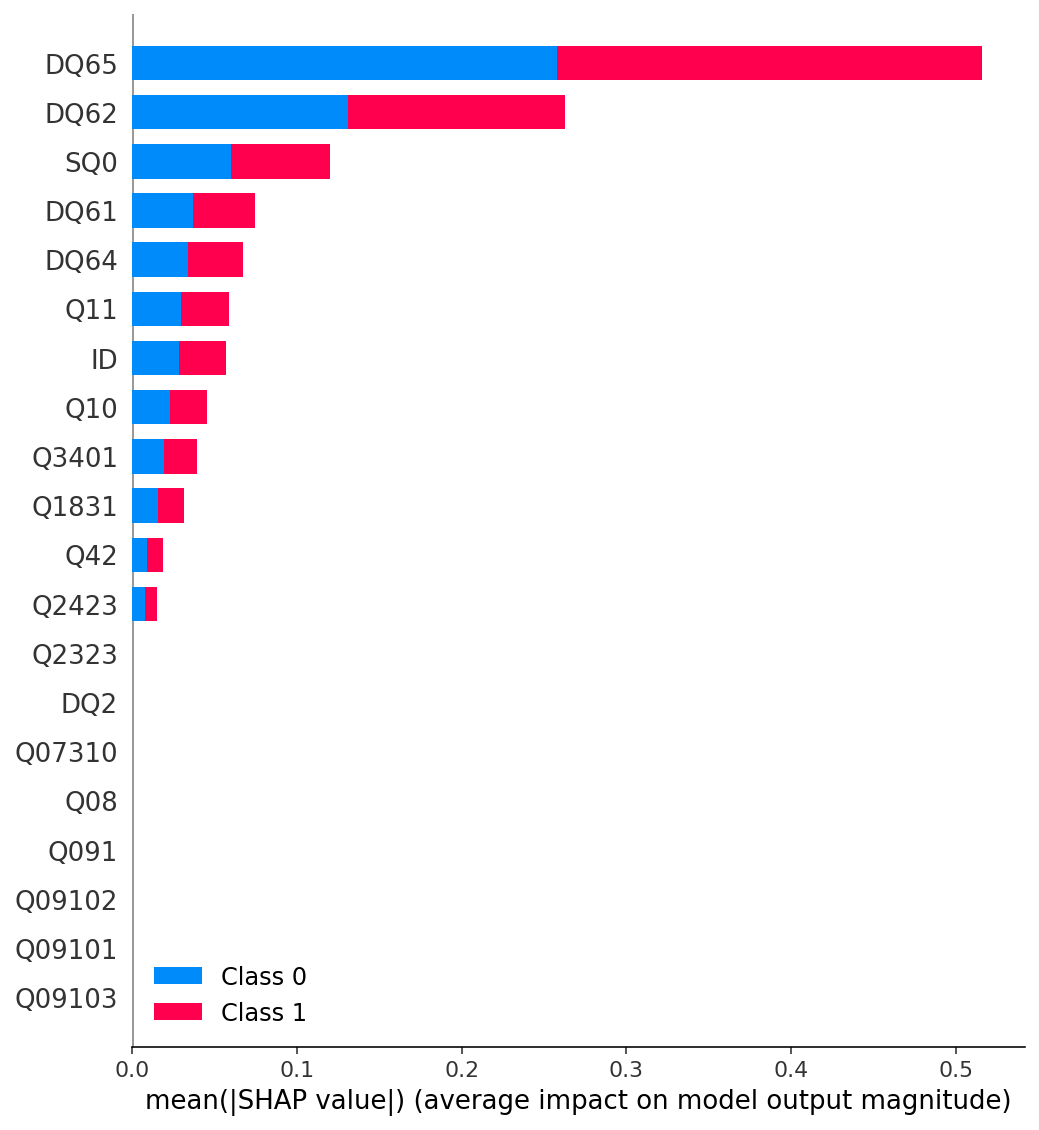

In [135]:
shap.summary_plot(shap_values, X_train)

y축은 각 특성을, x축은 Shapely value를 나타내고 있습니다. 색깔은 특성값을 나타내어 빨간색으로 갈수록 높은 값을 의미합니다. 그래프 상에서 특성은 예측에 미치는 영향력(=중요도)에 따라 정렬됩니다. 즉 DQ65가 결과값 예측에 가장 큰 영향을 끼치는 것입니다.

위 그래프를 보면, DQ65 특성값이 작을수록(파란색) 예측에 긍정적인 영향을, 클수록(빨간색) 부정적인 영향을 미치고 있습니다.

In [ ]:
shap_interaction_values = explainer.shap_values(pipe_decision[:-1].transform(X_train))
shap.summary_plot(shap_interaction_values, X_train)